In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import attr
import bz2
import ujson
import os
import umap
import random
import math

import numpy as np
import altair as alt
import pandas as pd

from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from itertools import islice
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import Counter
from multiprocessing import Pool
from functools import partial

In [20]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [22]:
ds = Dataset('../../data/top200-4bins.json/')

In [23]:
novels = list(ds.novels())

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


In [75]:
def cluster_by_token(token, n_clusters=4, min_count=50000):
    
    rows = []
    for n in novels:
        if n['word_count'] > min_count and min(n['counts'][token]):
            rows.append((n['corpus'], n['identifier'], n['counts'][token]))
            
    df = pd.DataFrame(rows, columns=('corpus', 'identifier', 'counts'))
    
    counts = np.stack(df.counts)
    
    counts = counts / counts.mean(1, keepdims=True)
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(counts)
    
    return df, counts, model

In [76]:
a_df, a_counts, a_model = cluster_by_token('a')

In [77]:
the_df, the_counts, the_model = cluster_by_token('the')

In [78]:
a_df

,corpus,identifier,counts
0,chicago,23808,"[501, 473, 484, 459]"
1,gale,AMFCF0002-C00000-B0595700,"[520, 423, 470, 452]"
2,gale,AMFCF0002-C00000-B1457300,"[484, 414, 406, 439]"
3,gale,AMFCF0002-C00000-B0328700,"[486, 456, 396, 378]"
4,gale,AMFCF0002-C00000-B0354800,"[352, 341, 319, 369]"
5,gale,AMFCF0003-C00000-B0034700,"[511, 468, 370, 406]"
6,gale,AMFCF0002-C00000-B0907702,"[477, 429, 434, 449]"
7,gale,AMFCF0003-C00000-B0152700,"[299, 321, 289, 259]"
8,gale,AMFCF0002-C00000-B1212200,"[478, 473, 508, 463]"
9,gale,AMFCF0002-C00000-B0726300,"[415, 346, 350, 343]"


In [40]:
def plot_clusters(counts, model):
    
    plt.figure(figsize=(10,6))
    
    groups = [
        counts[model.labels_==cid]
        for cid in np.unique(model.labels_)
    ]
    
    max_size = max([len(g) for g in groups])
    
    for g in groups:
        lw = 8 * (len(g) / max_size)
        plt.plot(g.mean(0), label=len(g), lw=lw)

    plt.legend()

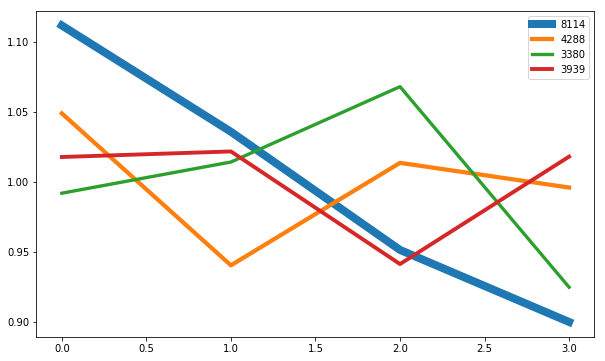

In [51]:
plot_clusters(a_counts, a_model)

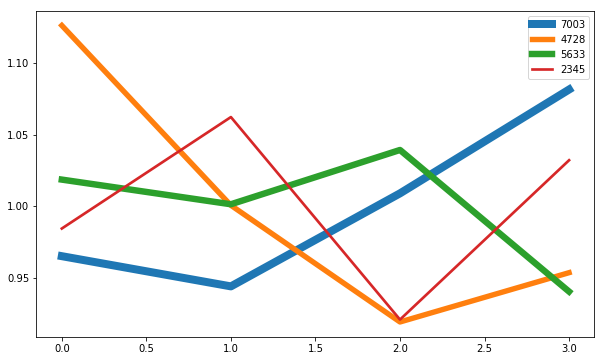

In [42]:
plot_clusters(the_counts, the_model)

In [3]:
def map_segment(func, path):
    """Parse JSON segment, apply worker function.
    """
    results = []
    
    with bz2.open(path) as fh:
        for line in fh:
            results.append(func(ujson.loads(line)))
            
    return results

In [4]:
@attr.s
class Corpus:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
                        
    def map_novels(self, func, shuffle=True):
        """Apply a worker to segment files in parallel.
        """
        paths = self.paths()
        
        if shuffle:
            random.shuffle(paths)
        
        with Pool() as p:
            
            worker = partial(map_segment, func)
            
            for results in p.imap_unordered(worker, paths):
                yield from results

In [5]:
corpus = Corpus('../../data/chicago-bins-tokens.json/')

In [15]:
def get_vocab(n):
    return [t.lower() for t in n['tokens']]

In [16]:
token_counts = Counter()

results = corpus.map_novels(get_vocab)
results = tqdm(islice(results, None))

for tokens in results:
    token_counts.update(tokens)

6638it [06:15, 17.66it/s]


In [43]:
vocab = [t for t, _ in token_counts.most_common(5000)]
vtoi = {v: i for i, v in enumerate(vocab)}

In [85]:
def _gather_counts(vtoi, n):
    """Get count vector for novel.
    """
    counts = np.zeros(len(vtoi))
    
    for t in n['tokens']:
        if t.lower() in vtoi:
            counts[vtoi[t.lower()]] += 1
        
    return n['identifier'], counts

In [91]:
worker = partial(_gather_counts, vtoi)

results = corpus.map_novels(worker)
results = tqdm(islice(results, 100))

ids, counts = zip(*results)


0it [00:00, ?it/s]
1it [00:02,  2.48s/it]
9it [00:02,  3.20it/s]
21it [00:03,  6.64it/s]
32it [00:03,  8.60it/s]
47it [00:04, 11.06it/s]
63it [00:04, 12.73it/s]
89it [00:05, 17.60it/s]
100it [00:05, 17.94it/s]


In [94]:
np.stack(counts)

array([[9.261e+03, 4.397e+03, 5.333e+03, ..., 0.000e+00, 2.000e+00,
        0.000e+00],
       [6.595e+03, 4.217e+03, 4.861e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [5.141e+03, 3.179e+03, 4.731e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [5.267e+03, 4.149e+03, 4.032e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [3.842e+03, 6.061e+03, 4.600e+03, ..., 0.000e+00, 3.000e+00,
        3.000e+00],
       [3.948e+03, 3.922e+03, 3.339e+03, ..., 0.000e+00, 2.000e+00,
        2.000e+00]])

In [90]:
a_df[a_df.corpus=='chicago']

,corpus,identifier,counts
0,chicago,23808,"[501, 473, 484, 459]"
18,chicago,26217,"[562, 565, 572, 478]"
20,chicago,24530,"[230, 221, 205, 210]"
21,chicago,25258,"[496, 450, 466, 433]"
25,chicago,24846,"[374, 305, 271, 229]"
27,chicago,20443,"[446, 428, 384, 377]"
28,chicago,24964,"[372, 324, 268, 321]"
29,chicago,25753,"[416, 469, 426, 360]"
34,chicago,22360,"[1106, 1113, 1024, 1010]"
36,chicago,11766,"[505, 429, 404, 411]"
